In [122]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys 
import os

# this line walks up file directory so rule-vetting is cwd
# Currently this breaks if chunk is run multiple times
os.chdir(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))))
print(os.getcwd())

import rulevetting.api.viz as viz
from rulevetting.projects.csi_pecarn.dataset import Dataset
from rulevetting.projects.csi_pecarn.tree_functions import *

from sklearn import tree
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay

df_all = Dataset().get_data()
df_ran = Dataset().get_data(control_types=['ran'])
df_moi = Dataset().get_data(control_types=['moi'])
df_ems = Dataset().get_data(control_types=['ems'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/


/Users/Yaxuan/opt/anaconda3/envs/“rule-env”/lib/python3.7/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


split_data kwargs {'control_types': ['ran', 'moi', 'ems']}
['ran', 'moi', 'ems']
split_data kwargs {'control_types': ['ran']}
['ran']
split_data kwargs {'control_types': ['moi']}
['moi']
split_data kwargs {'control_types': ['ems']}
['ems']


In [123]:
df = df_ran[0]
df.columns
#df[df['non_verbal'] == 1]

Index(['AlteredMentalStatus', 'LOC', 'FocalNeuroFindings', 'PainNeck',
       'PosMidNeckTenderness', 'TenderNeck', 'Torticollis', 'SubInj_Head',
       'SubInj_Face', 'SubInj_Ext', 'SubInj_TorsoTrunk', 'Predisposed',
       'HighriskDiving', 'HighriskFall', 'HighriskHanging', 'HighriskHitByCar',
       'HighriskMVC', 'HighriskOtherMV', 'AxialLoadAnyDoc', 'axialloadtop',
       'Clotheslining', 'CervicalSpineImmobilization', 'GCSEye', 'MotorGCS',
       'VerbalGCS', 'TotalGCS', 'PtCompPainFace', 'PtCompPainHead',
       'PtTenderNeck', 'PtTenderFace', 'PtTenderHead',
       'posthoc_CervicalSpinePrecautionsCC',
       'posthoc_CervicalSpinePrecautionsRLB',
       'posthoc_CervicalSpinePrecautionsOther',
       'posthoc_IntervForCervicalStabSCollar',
       'posthoc_IntervForCervicalStabRCollar',
       'posthoc_IntervForCervicalStabBrace',
       'posthoc_IntervForCervicalStabTraction',
       'posthoc_IntervForCervicalStabSurgical',
       'posthoc_IntervForCervicalStabHalo',
       '

In [132]:
def data_preparation(df, av, age, outside):
    posthoc_columns = [col for col in df.columns if 'posthoc' in col]
    outside_columns = [col for col in df.columns if 'outside' in col]
    av_list = ['AlteredMentalStatus', 'LOC', 'FocalNeuroFindings', 'PainNeck',
       'PosMidNeckTenderness', 'TenderNeck', 'Torticollis', 'SubInj_Head',
       'SubInj_Face', 'SubInj_Ext', 'SubInj_TorsoTrunk', 'Predisposed',
       'HighriskDiving', 'HighriskFall', 'HighriskHanging', 'HighriskHitByCar',
       'HighriskMVC', 'HighriskOtherMV', 'AxialLoadAnyDoc', 'axialloadtop',
       'Clotheslining', 'NonAmbulatory', 'csi_injury']
    
    if age == '<2':
        df = df[df['VeryYoung'] == 1]
    elif age == '2-5':
        df = df[(df['NonVerbal'] == 1) & (df['VeryYoung'] == 0)]
    elif age == '5-12':
        df = df[(df['YoungAdult'] == 0) & (df['NonVerbal'] == 0)]
    elif age == '>12':
        df = df[df['YoungAdult'] == 1]
        
    df = df.drop(['VeryYoung', 'NonVerbal','YoungAdult'],axis=1).copy()
    
    if av:
        df = df[av_list]
    elif outside:
        df = df.drop(posthoc_columns,axis=1).copy()
    else:
        df = df.drop(posthoc_columns,axis=1).copy()
        df = df.drop(outside_columns,axis=1).copy()   
        
    if age == '<2':
        df = df.drop(['NonAmbulatory'],axis=1).copy()
            
    return df

In [153]:
data_preparation(df,av = True, age = '<2', outside = False)

,,,,AlteredMentalStatus,LOC,FocalNeuroFindings,PainNeck,PosMidNeckTenderness,TenderNeck,Torticollis,SubInj_Head,SubInj_Face,SubInj_Ext,...,HighriskDiving,HighriskFall,HighriskHanging,HighriskHitByCar,HighriskMVC,HighriskOtherMV,AxialLoadAnyDoc,axialloadtop,Clotheslining,csi_injury
id,case_id,site,control_type,,,,,,,,,,,,,,,,,,,,,
140145,110022,1,ran,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
240245,210165,2,ran,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
240253,210162,2,ran,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
310283,310283,3,case,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
310286,310286,3,case,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1632930,1612798,16,moi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1632938,1612799,16,moi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1743307,1713128,17,ran,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Leonard et al(2011)

The sensitivity and specificity of the rule proposed by Leonard et al(2011) in three control groups

In [134]:
Leonard = ['AlteredMentalStatus','FocalNeuroFindings','PainNeck','Torticollis',
          'SubInj_TorsoTrunk','Predisposed','HighriskDiving','HighriskMVC']

## Decision trees

All models are trained on training set, and evaluate on tuning set.

The plots shows ROC curves for four different classifiers:

- CART
- CART with max_depth = 5
- Random Forest
- Random Forest with weighted class (10:1)

And the dashed lines mark the FPR and TPR of baselines.

Notice: TPR = sensitivity, FPR = 1-specificity

### control group: random

(377, 23) (134, 23)
[0.8928571428571429, 0.3333333333333333]


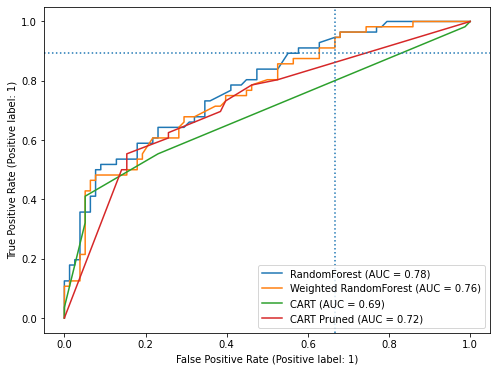

In [190]:
# control group: random

# data preparation --------------
data_list = avdf_ran
data_train = data_preparation(df_ran[0],av = True, age = '>12', outside = False)
data_tuning = data_preparation(df_ran[1],av = True, age = '>12', outside = False)
print(data_train.shape, data_tuning.shape)

Leo_evaluation = evaluate_vlist(data_tuning, Leonard)
print(Leo_evaluation)

# X = data_train.loc[:,'AlteredMentalStatus':'Clotheslining']
X = data_train.loc[:,'AlteredMentalStatus':'NonAmbulatory']
y = data_train['csi_injury'].astype('int')
# X_tuning = data_tuning.loc[:,'AlteredMentalStatus':'Clotheslining']
X_tuning = data_tuning.loc[:,'AlteredMentalStatus':'NonAmbulatory']
y_tuning = data_tuning['csi_injury'].astype('int')

# fiting models ---------------
cart = tree.DecisionTreeClassifier(random_state = 1)
cart = cart.fit(X,y)

cart_small = tree.DecisionTreeClassifier(max_depth = 3,random_state = 1)
cart_small = cart_small.fit(X,y)

rf = RandomForestClassifier(n_estimators = 200,random_state = 1)
rf = rf.fit(X,y)

rf_weighted = RandomForestClassifier(class_weight = {1:10, 0:1},random_state = 1)
rf_weighted = rf_weighted.fit(X,y)

# visulization --------------------
fig, ax = plt.subplots(figsize=(8,6))
RocCurveDisplay.from_estimator(rf, X_tuning, y_tuning, ax=ax, name = "RandomForest")
RocCurveDisplay.from_estimator(rf_weighted, X_tuning, y_tuning, ax=ax, name = "Weighted RandomForest")
RocCurveDisplay.from_estimator(cart_small, X_tuning, y_tuning, ax=ax, name = "CART")
RocCurveDisplay.from_estimator(cart, X_tuning, y_tuning, ax=ax, name = "CART Pruned")

ax.axhline(Leo_evaluation[0],linestyle = ":")
ax.axvline(1-Leo_evaluation[1],linestyle = ":")

plt.show()

[0.9155844155844156, 0.34080717488789236]


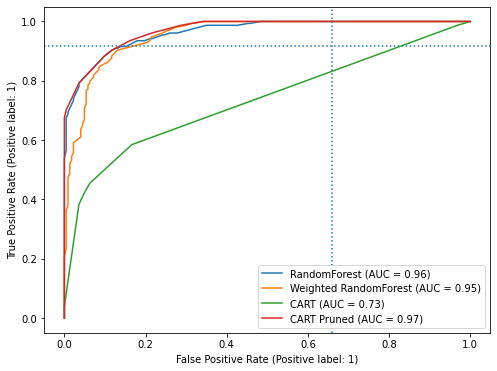

In [192]:

Leo_evaluation = evaluate_vlist(data_train, Leonard)
print(Leo_evaluation)

# visulization --------------------
fig, ax = plt.subplots(figsize=(8,6))
RocCurveDisplay.from_estimator(rf, X, y, ax=ax, name = "RandomForest")
RocCurveDisplay.from_estimator(rf_weighted, X, y, ax=ax, name = "Weighted RandomForest")
RocCurveDisplay.from_estimator(cart_small, X, y, ax=ax, name = "CART")
RocCurveDisplay.from_estimator(cart, X, y, ax=ax, name = "CART Pruned")

ax.axhline(Leo_evaluation[0],linestyle = ":")
ax.axvline(1-Leo_evaluation[1],linestyle = ":")

plt.show()

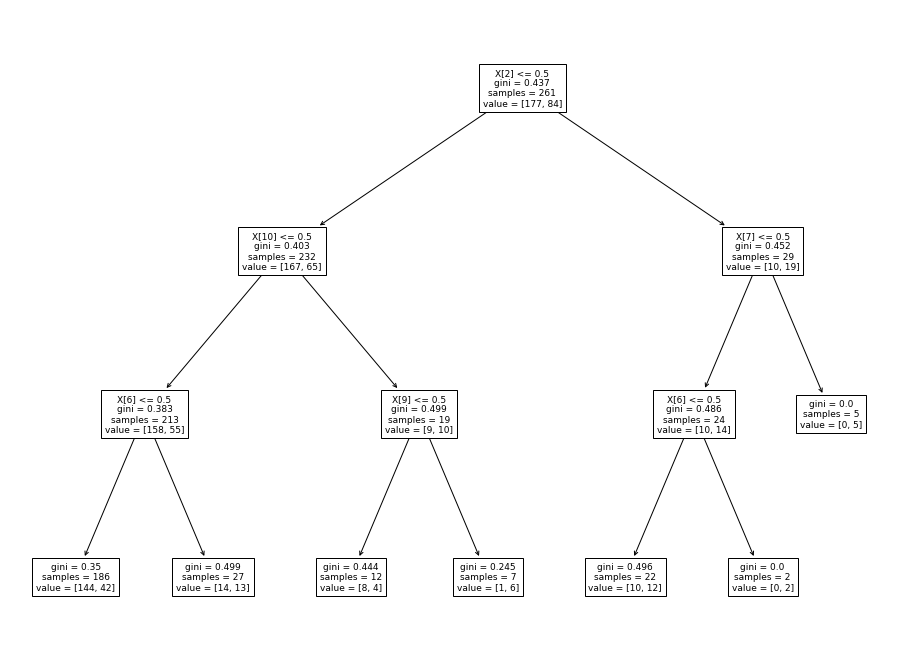

In [183]:
plt.figure(figsize=(16,12))  # set plot size (denoted in inches)
tree.plot_tree(cart_small, fontsize=9)
plt.show()    

In [147]:
X.columns[[0,1,5,11,13,16]]

Index(['AlteredMentalStatus', 'LOC', 'TenderNeck', 'Predisposed',
       'HighriskFall', 'HighriskMVC'],
      dtype='object')

In [165]:
evaluate_vlist(data_tuning, Leonard)

[1.0, 0.44]

In [193]:
print(data_tuning.shape)
print(evaluate_vlist(data_tuning, Leonard))
print(data_train.shape)
print(evaluate_vlist(data_train, Leonard))

(134, 23)
[0.8928571428571429, 0.3333333333333333]
(377, 23)
[0.9155844155844156, 0.34080717488789236]


In [185]:
data_tuning[data_tuning['csi_injury'] == 1]

,,,,AlteredMentalStatus,LOC,FocalNeuroFindings,PainNeck,PosMidNeckTenderness,TenderNeck,Torticollis,SubInj_Head,SubInj_Face,SubInj_Ext,...,HighriskFall,HighriskHanging,HighriskHitByCar,HighriskMVC,HighriskOtherMV,AxialLoadAnyDoc,axialloadtop,Clotheslining,NonAmbulatory,csi_injury
id,case_id,site,control_type,,,,,,,,,,,,,,,,,,,,,
110016,110016,1,case,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
310273,310273,3,case,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
310303,310303,3,case,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
310306,310306,3,case,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
310301,310301,3,case,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
410490,410490,4,case,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
610715,610715,6,case,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
610710,610710,6,case,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
710876,710876,7,case,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Simple Tree

### Using one variable at one time (same as Leonard)

In [203]:
results = simple_tree([data_train,data_tuning], tree_method = 'two', select_method = "semi_gini")
v = results[0]
e_tuning = results[2]

In [204]:
v

[['HighriskDiving', 'no need'],
 ['FocalNeuroFindings', 'no need'],
 ['Clotheslining', 'no need'],
 ['axialloadtop', 'no need'],
 ['Torticollis', 'no need'],
 ['HighriskMVC', 'no need'],
 ['SubInj_TorsoTrunk', 'LOC'],
 ['SubInj_Head', 'NonAmbulatory'],
 ['HighriskHanging', 'no observations'],
 ['PainNeck', 'no need'],
 ['SubInj_Face', 'AlteredMentalStatus'],
 ['TenderNeck', 'no need'],
 ['PosMidNeckTenderness', 'no observations'],
 ['AxialLoadAnyDoc', 'no need'],
 ['AlteredMentalStatus', 'LOC'],
 ['NonAmbulatory', 'Predisposed'],
 ['Predisposed', 'no observations'],
 ['HighriskOtherMV', 'no observations'],
 ['LOC', 'SubInj_Ext'],
 ['SubInj_Ext', 'HighriskHitByCar'],
 ['HighriskFall', 'no observations'],
 ['HighriskHitByCar', 'no variable']]

In [205]:
e_tuning

,num,TPR,FPR
0,0,0.000000,0.000000
1,1,0.107143,0.000000
2,2,0.428571,0.064103
3,3,0.428571,0.064103
4,4,0.500000,0.076923
5,5,0.517857,0.102564
6,6,0.660714,0.269231
7,7,0.678571,0.282051
8,8,0.714286,0.358974
9,9,0.714286,0.358974


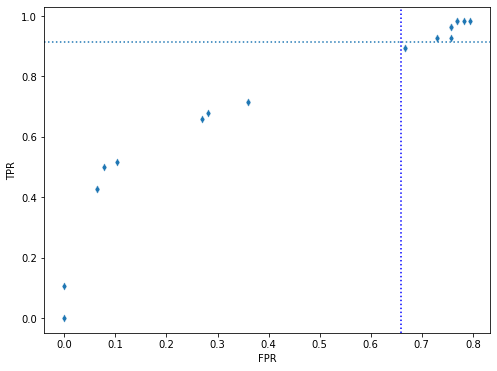

In [206]:
fig, ax = plt.subplots(figsize=(8,6))
ax.axhline(Leo_evaluation[0],linestyle = ":")
ax.axvline(1-Leo_evaluation[1],linestyle = ":",color = 'blue')
sns.scatterplot(x='FPR', y= 'TPR', data = e_tuning, marker='d')
# RocCurveDisplay.from_estimator(rf, X_tuning, y_tuning, ax=ax, name = "RandomForest")
plt.show()

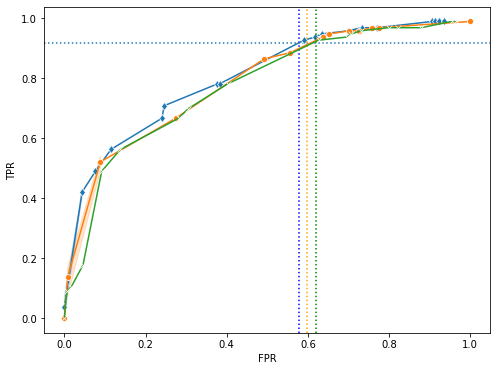

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
ax.axhline(Leo_evaluation_ran[0],linestyle = ":")
ax.axvline(1-Leo_evaluation_ran[1],linestyle = ":",color = 'blue')
sns.lineplot(x='FPR', y= 'TPR', data = e_ran_semi, marker='d')
# RocCurveDisplay.from_estimator(rf, X_tuning, y_tuning, ax=ax, name = "RandomForest")
plt.show()

### Using one or two variable(s) at one time

- threshold of whether use the second variable is sensitivity > 90%

In [12]:
results_ran = simple_tree(avdf_ran, tree_method = 'two', select_method = "gini")
v_ran = results_ran[0]
e_ran_tuning = results_ran[2]

results_ems = simple_tree(avdf_ems, tree_method = 'two', select_method = "gini")
v_ems = results_ems[0]
e_ems_tuning = results_ems[2]

results_moi = simple_tree(avdf_moi, tree_method = 'two', select_method = "gini")
v_moi = results_moi[0]
e_moi_tuning = results_moi[2]

results_ran_semi = simple_tree(avdf_ran, tree_method = 'two', select_method = "semi_gini")
v_ran_semi = results_ran_semi[0]
e_ran_semi = results_ran_semi[2]

results_ems_semi = simple_tree(avdf_ems, tree_method = 'two', select_method = "semi_gini")
v_ems_semi = results_ems_semi[0]
e_ems_semi = results_ems_semi[2]

results_moi_semi = simple_tree(avdf_moi, tree_method = 'two', select_method = "semi_gini")
v_moi_semi = results_moi_semi[0]
e_moi_semi = results_moi_semi[2]

In [13]:
summary_df = pd.DataFrame(data = {})

v_0 = []
v_1 = []
for v in v_ran:
    v_0.append(v[0])
    v_1.append(v[1])
summary_df['ran_0'] = v_0
summary_df['ran_1'] = v_1

v_0 = []
v_1 = []
for v in v_ems:
    v_0.append(v[0])
    v_1.append(v[1])
summary_df['ems_0'] = v_0
summary_df['ems_1'] = v_1

v_0 = []
v_1 = []
for v in v_moi:
    v_0.append(v[0])
    v_1.append(v[1])
summary_df['moi_0'] = v_0
summary_df['moi_1'] = v_1

summary_df

,ran_0,ran_1,ems_0,ems_1,moi_0,moi_1
0,FocalNeuroFindings,no need,FocalNeuroFindings,no need,FocalNeuroFindings,no need
1,HighriskDiving,no need,Torticollis,no need,AlteredMentalStatus,no need
2,AlteredMentalStatus,no need,AlteredMentalStatus,no need,PainNeck,no need
3,PainNeck,no need,PainNeck,no need,Torticollis,no need
4,Torticollis,no need,HighriskDiving,no need,Predisposed,NonAmbulatory
5,Predisposed,no need,Predisposed,NonAmbulatory,HighriskDiving,no need
6,Clotheslining,no need,Clotheslining,no need,Clotheslining,no need
7,TenderNeck,no need,HighriskMVC,no need,HighriskMVC,no need
8,HighriskMVC,no need,PosMidNeckTenderness,no need,SubInj_TorsoTrunk,HighriskHitByCar
9,NonAmbulatory,axialloadtop,LOC,HighriskHitByCar,TenderNeck,no need


In [14]:
summary_df = pd.DataFrame(data = {})

v_0 = []
v_1 = []
for v in v_ran_semi:
    v_0.append(v[0])
    v_1.append(v[1])
summary_df['ran_semi_0'] = v_0
summary_df['ran_semi_1'] = v_1

v_0 = []
v_1 = []
for v in v_ems_semi:
    v_0.append(v[0])
    v_1.append(v[1])
summary_df['ems_semi_0'] = v_0
summary_df['ems_semi_1'] = v_1

v_0 = []
v_1 = []
for v in v_moi_semi:
    v_0.append(v[0])
    v_1.append(v[1])
summary_df['moi_semi_0'] = v_0
summary_df['moi_semi_1'] = v_1

summary_df

,ran_semi_0,ran_semi_1,ems_semi_0,ems_semi_1,moi_semi_0,moi_semi_1
0,HighriskDiving,no need,HighriskDiving,no need,HighriskDiving,no need
1,FocalNeuroFindings,no need,Torticollis,no need,Predisposed,no need
2,Predisposed,no need,Clotheslining,no need,Clotheslining,no need
3,Clotheslining,no need,FocalNeuroFindings,no need,SubInj_TorsoTrunk,no need
4,SubInj_TorsoTrunk,NonAmbulatory,axialloadtop,no need,FocalNeuroFindings,no need
5,Torticollis,no need,Predisposed,NonAmbulatory,Torticollis,no need
6,HighriskMVC,no need,AlteredMentalStatus,no need,AlteredMentalStatus,no need
7,axialloadtop,no need,PainNeck,no need,HighriskHanging,no observations
8,AlteredMentalStatus,no need,PosMidNeckTenderness,no need,axialloadtop,no need
9,HighriskHanging,no observations,HighriskMVC,no need,HighriskMVC,no need


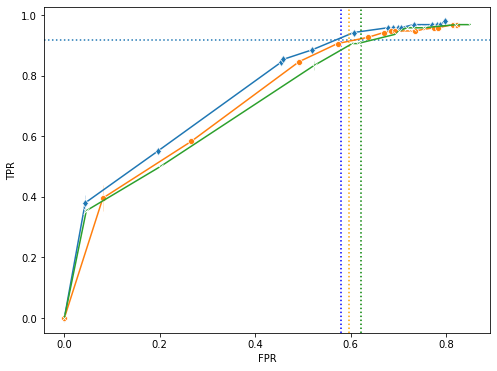

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
ax.axhline(Leo_evaluation_ran[0],linestyle = ":")
ax.axvline(1-Leo_evaluation_ran[1],linestyle = ":",color = 'blue')
sns.lineplot(x='FPR', y= 'TPR', data = e_ran_tuning, marker='d')
ax.axvline(1-Leo_evaluation_ems[1],linestyle = ":",color = 'orange')
sns.lineplot(x='FPR', y= 'TPR', data = e_ems_tuning, marker='o')
ax.axvline(1-Leo_evaluation_moi[1],linestyle = ":",color = 'green')
sns.lineplot(x='FPR', y= 'TPR', data = e_moi_tuning,  marker='x')
# RocCurveDisplay.from_estimator(rf, X_tuning, y_tuning, ax=ax, name = "RandomForest")
plt.show()

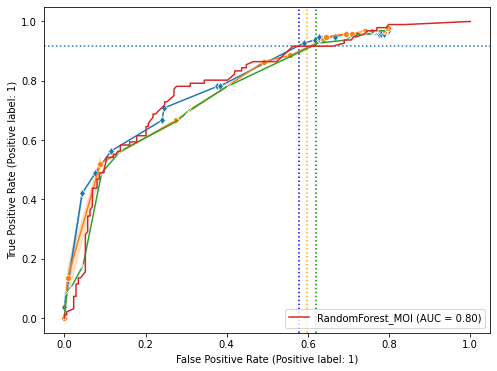

In [18]:
fig, ax = plt.subplots(figsize=(8,6))
ax.axhline(Leo_evaluation_ran[0],linestyle = ":")
ax.axvline(1-Leo_evaluation_ran[1],linestyle = ":",color = 'blue')
sns.lineplot(x='FPR', y= 'TPR', data = e_ran_semi, marker='d')
ax.axvline(1-Leo_evaluation_ems[1],linestyle = ":",color = 'orange')
sns.lineplot(x='FPR', y= 'TPR', data = e_ems_semi, marker='o')
ax.axvline(1-Leo_evaluation_moi[1],linestyle = ":",color = 'green')
sns.lineplot(x='FPR', y= 'TPR', data = e_moi_semi,  marker='x')
RocCurveDisplay.from_estimator(rf, X_tuning, y_tuning, ax=ax, name = "RandomForest_MOI")
# RocCurveDisplay.from_estimator(rf, X_tuning, y_tuning, ax=ax, name = "RandomForest")
plt.show()